In [21]:
# 0) Install once (run only if imports fail later)
# !pip install pandas numpy scikit-learn seaborn matplotlib joblib


In [22]:
# 1) Imports, folders, environment checks
import os, sys, warnings
warnings.filterwarnings('ignore', category=FutureWarning)

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    roc_auc_score, roc_curve, confusion_matrix, classification_report
)

# Create output folders
for d in ["outputs/eda_plots","outputs/reports","outputs/models","outputs/predictions"]:
    os.makedirs(d, exist_ok=True)

print("Python:", sys.version)
print("CWD:", os.getcwd())
print("Here:", os.listdir())


Python: 3.13.5 | packaged by Anaconda, Inc. | (main, Jun 12 2025, 16:37:03) [MSC v.1929 64 bit (AMD64)]
CWD: C:\Users\chira\LR
Here: ['.ipynb_checkpoints', 'ASSIGNMENT_07.ipynb', 'outputs', 'titanic_logreg_pipeline.pkl', 'Titanic_test.csv', 'Titanic_train.csv']


In [23]:
# 2) Load data (ensure these CSVs sit next to the notebook)
train = pd.read_csv("Titanic_train.csv")
test = pd.read_csv("Titanic_test.csv")
print("Loaded. Train:", train.shape, "Test:", test.shape)
train.head()


Loaded. Train: (891, 12) Test: (418, 11)


,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [24]:
# 3) Feature engineering used in EDA and modeling
def extract_title(name: str) -> str:
    if pd.isna(name): return "Unknown"
    t = name.split(",")[1].split(".")[0].strip()
    mapping = {
        "Mlle":"Miss","Ms":"Miss","Mme":"Mrs",
        "Lady":"Royal","Countess":"Royal","Sir":"Royal","Don":"Royal","Dona":"Royal","Jonkheer":"Royal",
        "Capt":"Officer","Col":"Officer","Major":"Officer","Dr":"Officer","Rev":"Officer"
    }
    return mapping.get(t, t)

for df in [train, test]:
    df["Title"] = df["Name"].apply(extract_title)
    df["FamilySize"] = df["SibSp"] + df["Parch"] + 1
    df["IsAlone"] = (df["FamilySize"] == 1).astype(int)

train[["Title","FamilySize","IsAlone"]].head()


,Title,FamilySize,IsAlone
0,Mr,2,0
1,Mrs,2,0
2,Miss,1,1
3,Mrs,2,0
4,Mr,1,1


In [25]:
# 4) 1. Data Exploration snapshots (dtypes, missing, category counts, numerics)
print("Dtypes:\n", train.dtypes, "\n")
print("Missing values (train):\n", train.isna().sum().sort_values(ascending=False).head(12), "\n")

for col in ["Sex","Embarked","Pclass","Title","IsAlone"]:
    if col in train.columns:
        vc = train[col].value_counts(dropna=False)
        print(f"Value counts for {col}:\n", vc, "\n")

print("Numeric summary:\n", train.select_dtypes(include=[np.number]).describe().T)

# Save overview for the report
overview = pd.DataFrame({
    "column": train.columns,
    "dtype": train.dtypes.astype(str).values,
    "missing": train.isna().sum().values,
    "unique": [train[c].nunique() for c in train.columns]
})
overview.to_csv("outputs/reports/data_overview_train.csv", index=False)


Dtypes:
 PassengerId      int64
Survived         int64
Pclass           int64
Name            object
Sex             object
Age            float64
SibSp            int64
Parch            int64
Ticket          object
Fare           float64
Cabin           object
Embarked        object
Title           object
FamilySize       int64
IsAlone          int64
dtype: object 

Missing values (train):
 Cabin          687
Age            177
Embarked         2
Pclass           0
Name             0
Survived         0
PassengerId      0
SibSp            0
Sex              0
Ticket           0
Parch            0
Fare             0
dtype: int64 

Value counts for Sex:
 Sex
male      577
female    314
Name: count, dtype: int64 

Value counts for Embarked:
 Embarked
S      644
C      168
Q       77
NaN      2
Name: count, dtype: int64 

Value counts for Pclass:
 Pclass
3    491
1    216
2    184
Name: count, dtype: int64 

Value counts for Title:
 Title
Mr              517
Miss            185
Mrs        

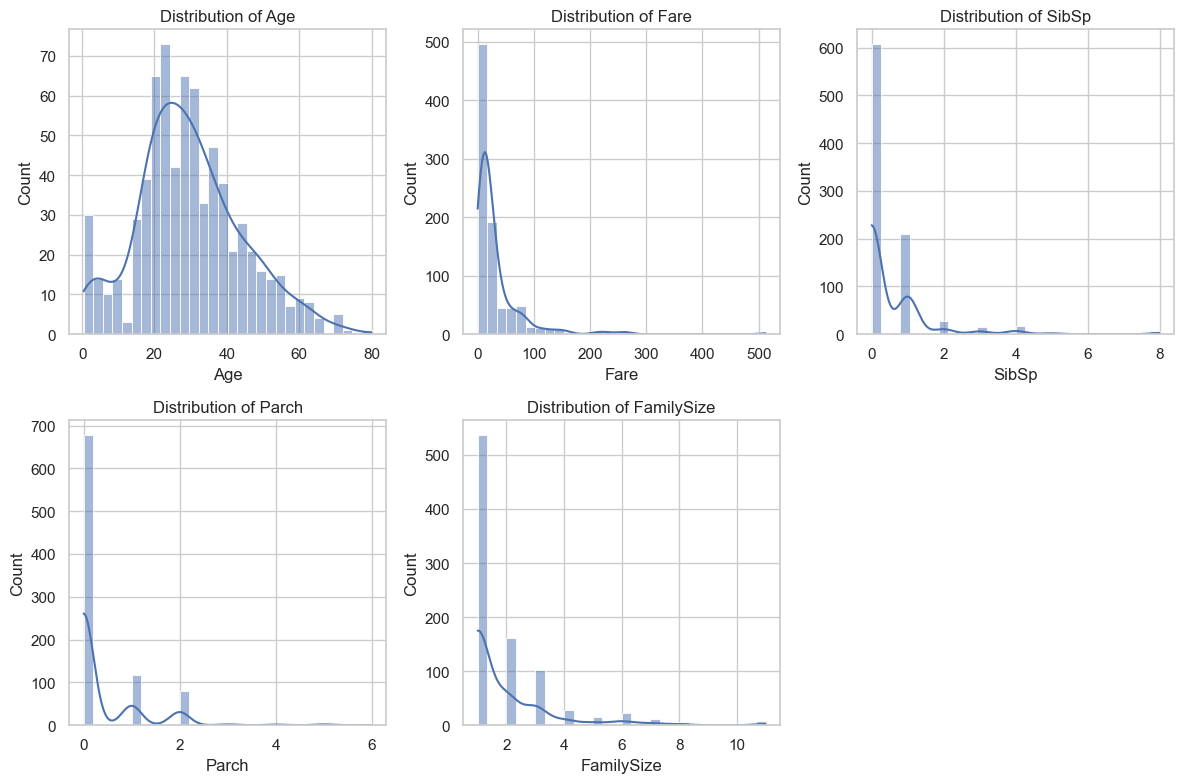

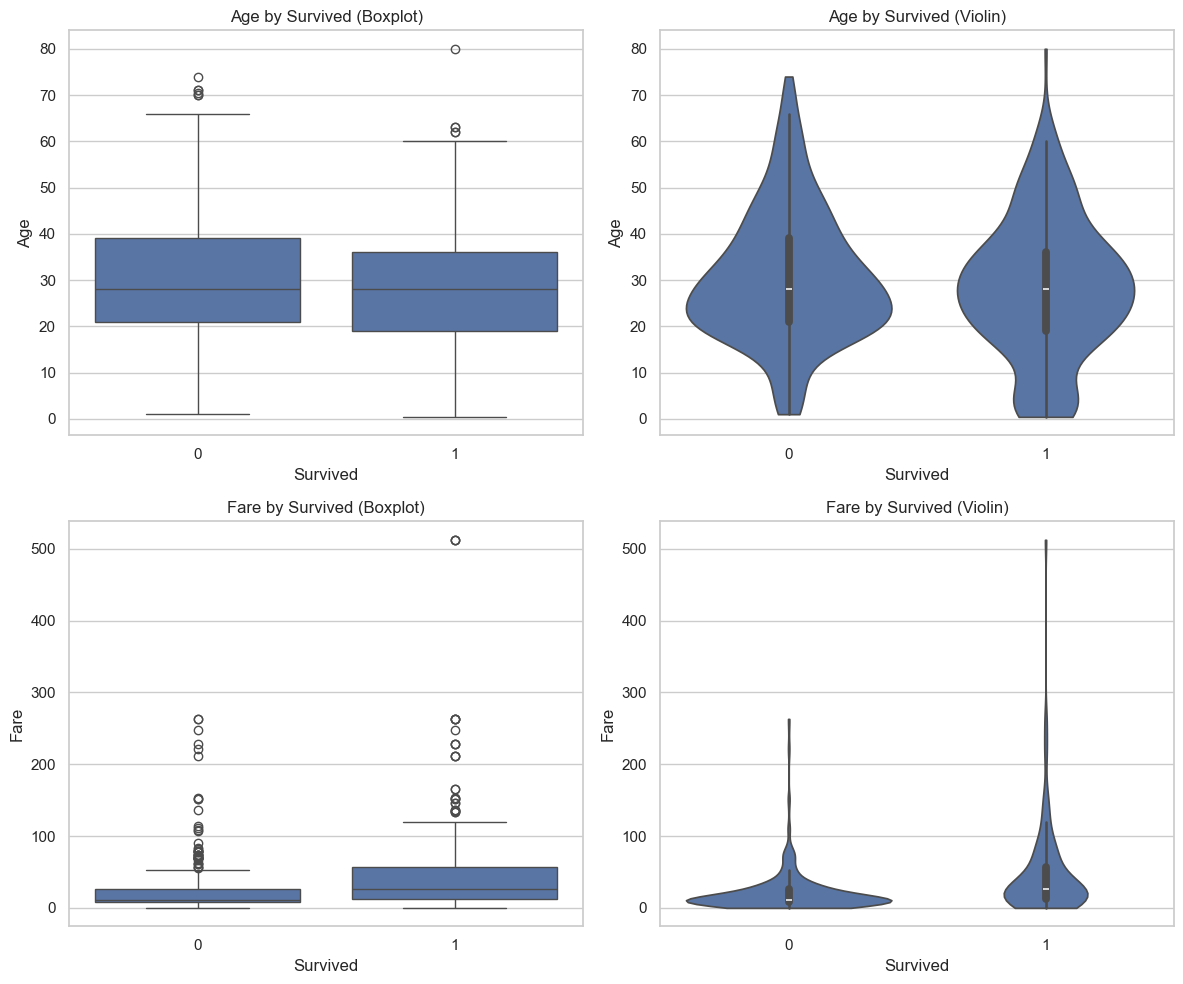

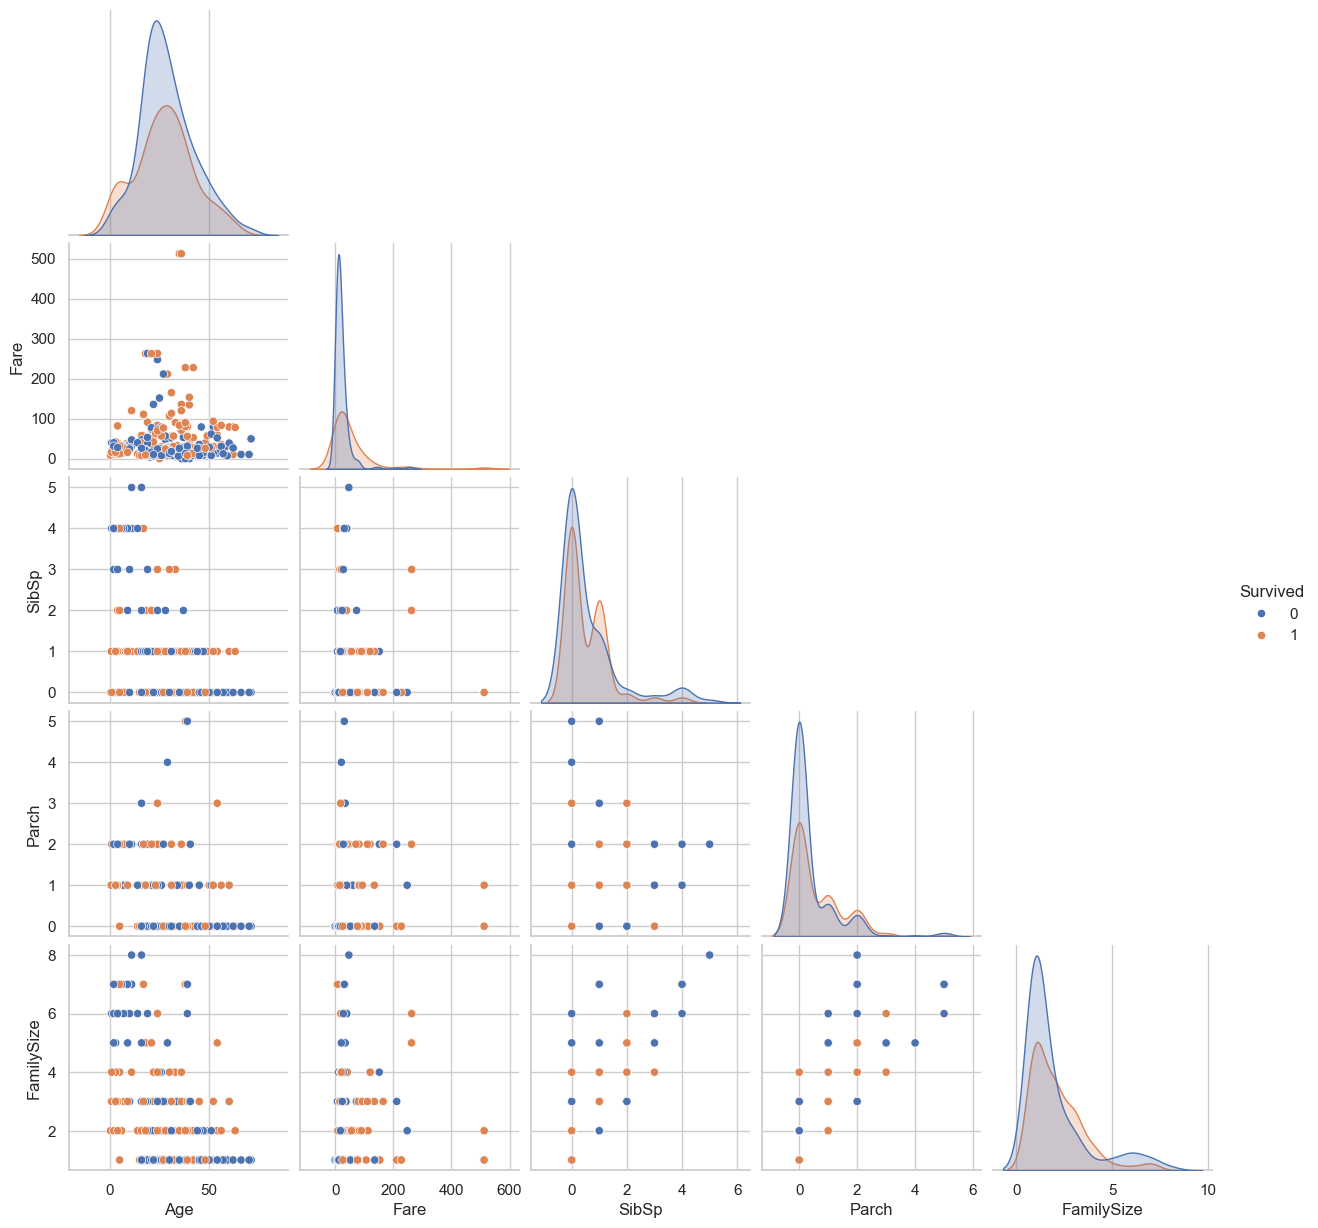

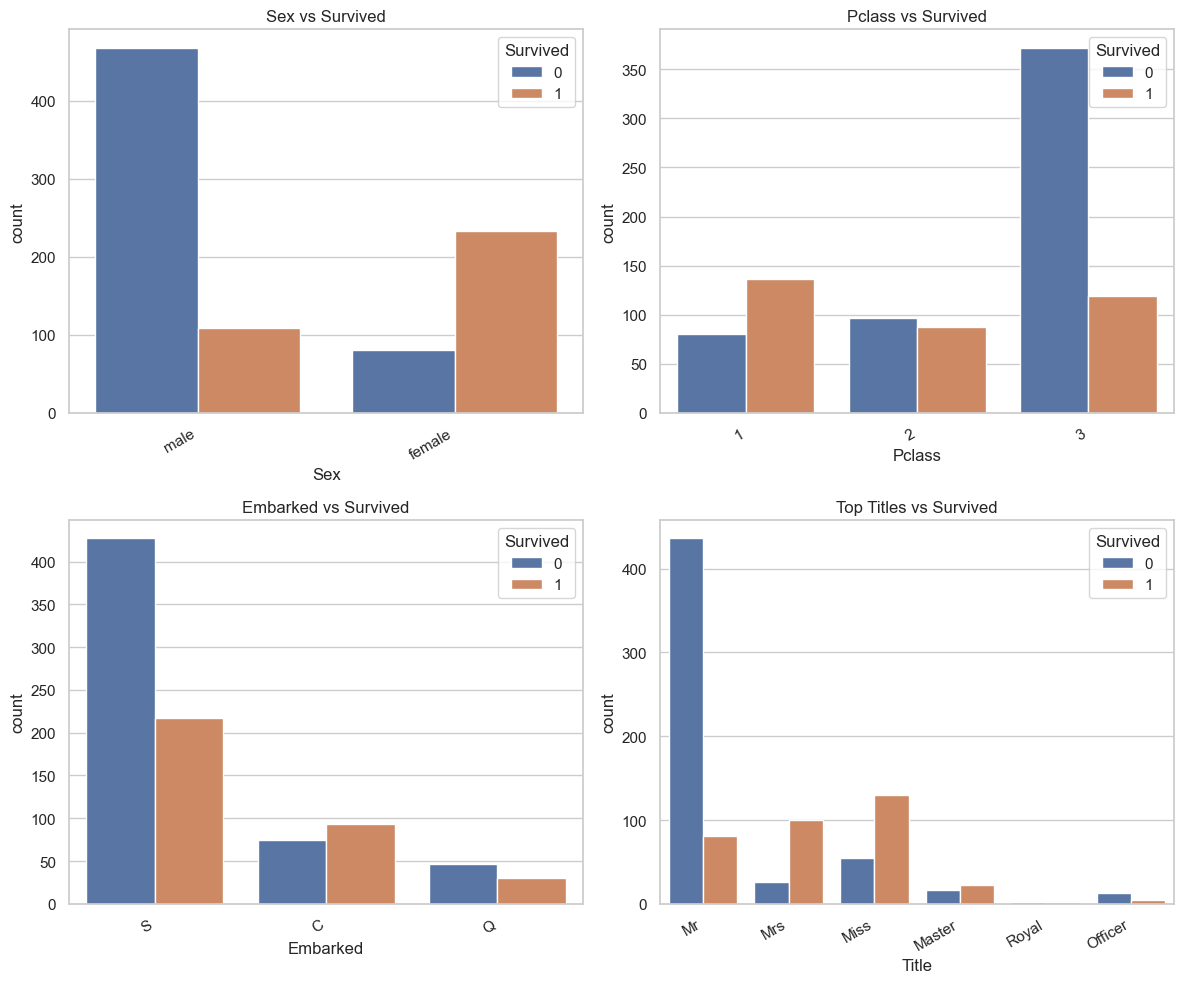

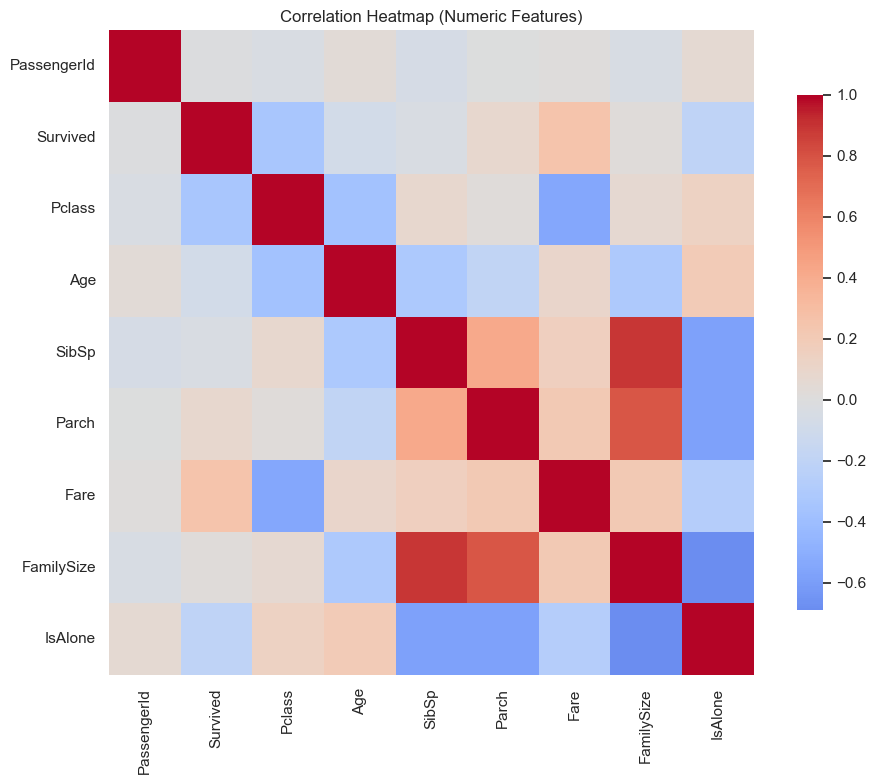

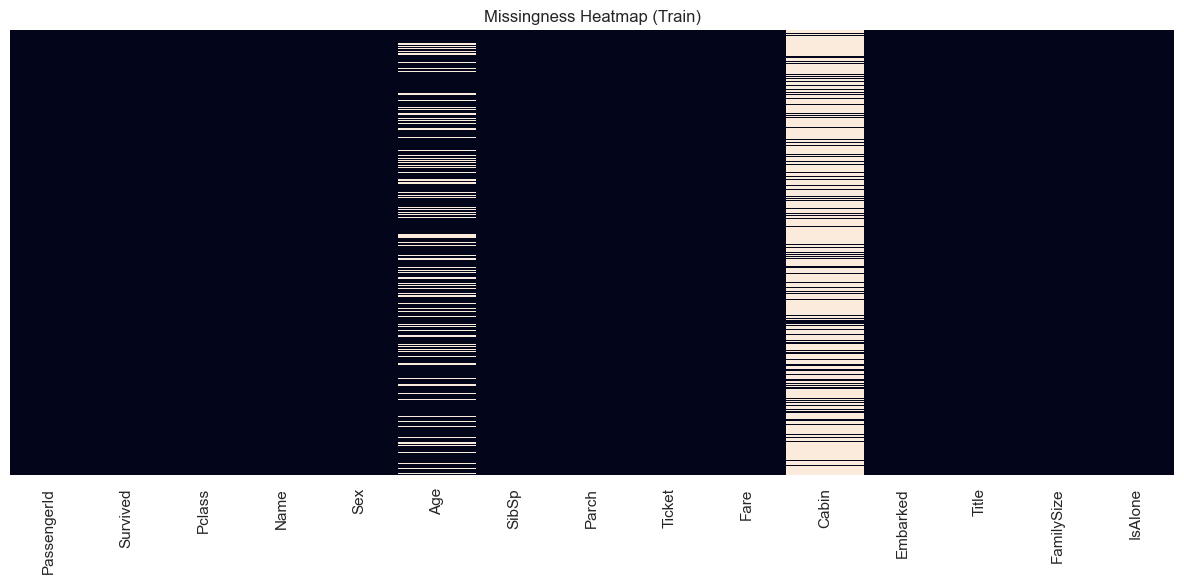

In [26]:
# 5a) Histograms
sns.set_theme(style='whitegrid', context='notebook')
plt.figure(figsize=(12, 8))
for i, col in enumerate(["Age","Fare","SibSp","Parch","FamilySize"], 1):
    plt.subplot(2, 3, i)
    sns.histplot(train[col], bins=30, kde=True, color="#4C72B0")
    plt.title(f"Distribution of {col}")
plt.tight_layout()
plt.savefig("outputs/eda_plots/hist_numeric.png", dpi=150, bbox_inches="tight")
plt.show()

# 5b) Box & Violin by Survived
fig, axes = plt.subplots(2, 2, figsize=(12, 10))
sns.boxplot(data=train, x="Survived", y="Age", ax=axes[0,0]); axes[0,0].set_title("Age by Survived (Boxplot)")
sns.violinplot(data=train, x="Survived", y="Age", ax=axes[0,1], cut=0); axes[0,1].set_title("Age by Survived (Violin)")
sns.boxplot(data=train, x="Survived", y="Fare", ax=axes[1,0]); axes[1,0].set_title("Fare by Survived (Boxplot)")
sns.violinplot(data=train, x="Survived", y="Fare", ax=axes[1,1], cut=0); axes[1,1].set_title("Fare by Survived (Violin)")
plt.tight_layout()
plt.savefig("outputs/eda_plots/box_violin_age_fare_by_survived.png", dpi=150, bbox_inches="tight")
plt.show()

# 5c) Pair plot (sampled)
pp = train[["Age","Fare","SibSp","Parch","FamilySize","Survived"]].dropna()
if len(pp) > 400:
    pp = pp.sample(400, random_state=42)
g = sns.pairplot(pp, vars=["Age","Fare","SibSp","Parch","FamilySize"], hue="Survived", diag_kind="kde", corner=True)
g.savefig("outputs/eda_plots/pairplot_selected.png", dpi=150, bbox_inches="tight")
plt.show()

# 5d) Categorical countplots
fig, axes = plt.subplots(2, 2, figsize=(12, 10))
sns.countplot(data=train, x="Sex", hue="Survived", ax=axes[0,0]); axes[0,0].set_title("Sex vs Survived")
sns.countplot(data=train, x="Pclass", hue="Survived", ax=axes[0,1]); axes[0,1].set_title("Pclass vs Survived")
sns.countplot(data=train, x="Embarked", hue="Survived", ax=axes[1,0]); axes[1,0].set_title("Embarked vs Survived")
top_titles = train["Title"].value_counts().nlargest(6).index
sns.countplot(data=train[train["Title"].isin(top_titles)], x="Title", hue="Survived", ax=axes[1,1]); axes[1,1].set_title("Top Titles vs Survived")
for ax in axes.ravel():
    for lab in ax.get_xticklabels():
        lab.set_rotation(30); lab.set_horizontalalignment("right")
plt.tight_layout()
plt.savefig("outputs/eda_plots/countplots_categorical.png", dpi=150, bbox_inches="tight")
plt.show()

# 5e) Correlation and Missingness heatmaps
num_cols = train.select_dtypes(include=[np.number]).columns
plt.figure(figsize=(10, 8))
sns.heatmap(train[num_cols].corr(numeric_only=True), cmap="coolwarm", center=0, square=True, cbar_kws={"shrink": .8})
plt.title("Correlation Heatmap (Numeric Features)")
plt.tight_layout()
plt.savefig("outputs/eda_plots/corr_heatmap.png", dpi=150, bbox_inches="tight")
plt.show()

plt.figure(figsize=(12, 6))
sns.heatmap(train.isna(), cbar=False, yticklabels=False)
plt.title("Missingness Heatmap (Train)")
plt.tight_layout()
plt.savefig("outputs/eda_plots/missingness_heatmap.png", dpi=150, bbox_inches="tight")
plt.show()


In [27]:
# 6) 2. Data Preprocessing — select features and define baseline-coded transformers
TARGET = "Survived"
feature_cols = ["Pclass","Sex","Age","SibSp","Parch","Fare","Embarked","Title","FamilySize","IsAlone"]

X = train[feature_cols]
y = train[TARGET]
X_test = test[feature_cols]

numeric_features = ["Age","SibSp","Parch","Fare","FamilySize","IsAlone"]
categorical_features = ["Pclass","Sex","Embarked","Title"]

numeric_transformer = Pipeline([
    ("imputer", SimpleImputer(strategy="median")),
    ("scaler", StandardScaler())
])

# Baseline-coded: drop='first' yields explicit reference level for each categorical
categorical_transformer = Pipeline([
    ("imputer", SimpleImputer(strategy="most_frequent")),
    ("onehot", OneHotEncoder(drop="first", handle_unknown="ignore"))
])

preprocess = ColumnTransformer([
    ("num", numeric_transformer, numeric_features),
    ("cat", categorical_transformer, categorical_features)
])

print("Preprocessing ready (baseline-coded).")


Preprocessing ready (baseline-coded).


In [28]:
# 7) 3. Model building — Logistic Regression in a Pipeline
clf = Pipeline([("preprocess", preprocess),
                ("model", LogisticRegression(max_iter=1000, solver="liblinear"))])
print("Model pipeline created.")


Model pipeline created.


In [29]:
# 8) Train/validation split (test has no labels)
X_tr, X_val, y_tr, y_val = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)
print("Train/Val shapes:", X_tr.shape, X_val.shape)


Train/Val shapes: (712, 10) (179, 10)


Validation metrics: {'accuracy': 0.8379888268156425, 'precision': 0.8225806451612904, 'recall': 0.7391304347826086, 'f1': 0.7786259541984732, 'roc_auc': 0.8805006587615284}


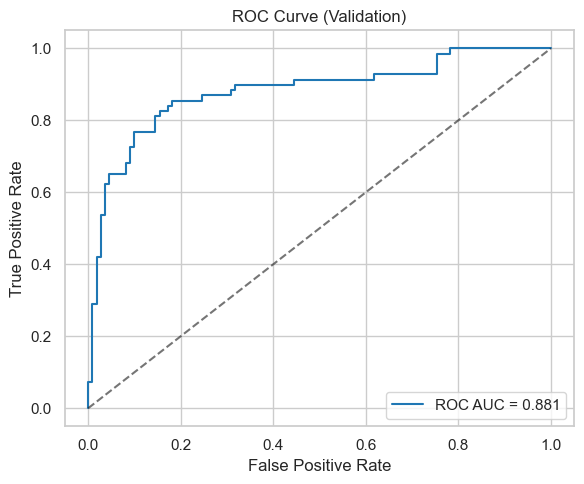

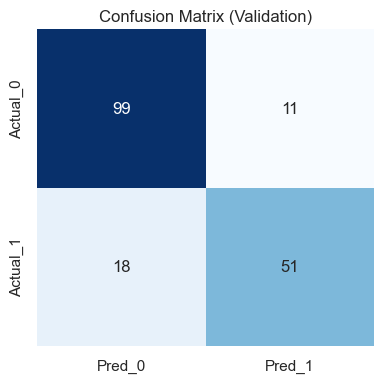

In [35]:
y_val_pred = clf.predict(X_val)
y_val_proba = clf.predict_proba(X_val)[:, 1]

metrics = {
    "accuracy": float(accuracy_score(y_val, y_val_pred)),
    "precision": float(precision_score(y_val, y_val_pred)),
    "recall": float(recall_score(y_val, y_val_pred)),
    "f1": float(f1_score(y_val, y_val_pred)),
    "roc_auc": float(roc_auc_score(y_val, y_val_proba)),
}
print("Validation metrics:", metrics)

pd.DataFrame([metrics]).to_csv("outputs/reports/evaluation_metrics_val.csv", index=False)
cm = confusion_matrix(y_val, y_val_pred)
pd.DataFrame(cm, index=["Actual_0","Actual_1"], columns=["Pred_0","Pred_1"]).to_csv("outputs/reports/confusion_matrix_val.csv")
pd.DataFrame(classification_report(y_val, y_val_pred, output_dict=True)).transpose().to_csv("outputs/reports/classification_report_val.csv")
fpr, tpr, thresholds = roc_curve(y_val, y_val_proba)
pd.DataFrame({"fpr": fpr, "tpr": tpr, "threshold": thresholds}).to_csv("outputs/reports/roc_curve_points_val.csv", index=False)

# ROC curve plot
plt.figure(figsize=(6,5))
plt.plot(fpr, tpr, label=f"ROC AUC = {metrics['roc_auc']:.3f}", color="#1f77b4")
plt.plot([0,1],[0,1],"k--", alpha=0.6)
plt.xlabel("False Positive Rate"); plt.ylabel("True Positive Rate"); plt.title("ROC Curve (Validation)")
plt.legend(loc="lower right")
plt.tight_layout()
plt.savefig("outputs/eda_plots/roc_curve_val.png", dpi=150, bbox_inches="tight")
plt.show()

# Confusion matrix heatmap
plt.figure(figsize=(4,4))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", cbar=False, xticklabels=["Pred_0","Pred_1"], yticklabels=["Actual_0","Actual_1"])
plt.title("Confusion Matrix (Validation)")
plt.tight_layout()
plt.savefig("outputs/eda_plots/confusion_matrix_val.png", dpi=150, bbox_inches="tight")
plt.show()

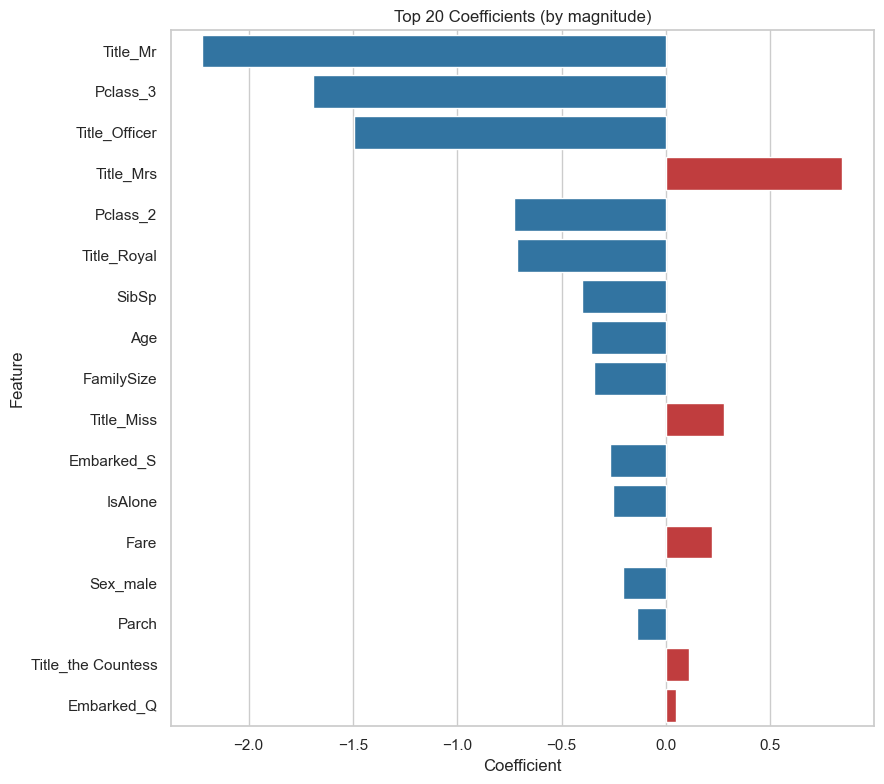

Saved: outputs/reports/model_coefficients_exact.csv and outputs/eda_plots/top_coefficients_exact.png


In [31]:
# 10) Refit on full train and interpret with exact feature names (baseline-coded, legend fix)

# Imports (safe to re-import in a cell)
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# 1) Refit the pipeline on the full training data
# Assumes 'clf' is your fitted Pipeline object from previous steps and X, y are defined
clf.fit(X, y)

# 2) Get transformed feature names in the exact order produced by the ColumnTransformer
pre = clf.named_steps["preprocess"]

def get_exact_feature_names(preprocessor):
    # Best path: ColumnTransformer provides names directly in newer scikit-learn
    if hasattr(preprocessor, "get_feature_names_out"):
        return list(preprocessor.get_feature_names_out())

    # Fallback: build from components for older versions
    # Find the 'num' and 'cat' transformers and their original column lists
    cols_map = {}
    for name, trans, cols in preprocessor.transformers_:
        if name in ("num", "cat"):
            cols_map[name] = list(cols)

    num_cols = cols_map.get("num", [])
    cat_cols = cols_map.get("cat", [])

    # Get encoded categorical names from the fitted OneHotEncoder
    ohe = preprocessor.named_transformers_["cat"].named_steps["onehot"]
    if hasattr(ohe, "get_feature_names_out"):
        cat_feature_names = list(ohe.get_feature_names_out(cat_cols))
    else:
        cat_feature_names = list(ohe.get_feature_names(cat_cols))

    # Prefix to mirror ColumnTransformer naming convention
    num_names = [f"num__{c}" for c in num_cols]
    cat_names = [f"cat__{c}" for c in cat_feature_names]
    return num_names + cat_names

feature_names = get_exact_feature_names(pre)

# 3) Map coefficients to names and compute odds ratios (per 1 SD for numerics due to StandardScaler)
coefs = clf.named_steps["model"].coef_[0]
coef_df = pd.DataFrame({"feature_raw": feature_names, "coefficient": coefs})
coef_df["feature"] = (
    coef_df["feature_raw"]
      .str.replace("num__","", regex=False)
      .str.replace("cat__","", regex=False)
)
coef_df["odds_ratio"] = np.exp(coef_df["coefficient"])
coef_df["abs_coef"] = coef_df["coefficient"].abs()
coef_df["sign"] = np.where(coef_df["coefficient"] >= 0, "positive", "negative")

# Save full table
coef_df.sort_values("abs_coef", ascending=False).to_csv(
    "outputs/reports/model_coefficients_exact.csv", index=False
)

# 4) Plot top coefficients (Seaborn 0.14+ compliant, safe legend removal)
top = coef_df.sort_values("abs_coef", ascending=False).head(20)

fig, ax = plt.subplots(figsize=(9, 8))
sns.barplot(
    data=top,
    y="feature",
    x="coefficient",
    hue="sign",                    # keeps Seaborn happy and informative coloring
    dodge=False,
    palette={"positive":"#d62728","negative":"#1f77b4"},
    ax=ax
)
ax.set_title("Top 20 Coefficients (by magnitude)")
ax.set_xlabel("Coefficient"); ax.set_ylabel("Feature")

# Remove legend safely from the Axes (avoid AttributeError on plt.legend_)
leg = ax.get_legend()
if leg is not None:
    leg.remove()

fig.tight_layout()
fig.savefig("outputs/eda_plots/top_coefficients_exact.png", dpi=150, bbox_inches="tight")
plt.show()

print("Saved: outputs/reports/model_coefficients_exact.csv and outputs/eda_plots/top_coefficients_exact.png")


In [32]:
# 11) Predict on test and save submission
test_pred = clf.predict(X_test)
pd.DataFrame({"PassengerId": test["PassengerId"], "Survived": test_pred}).to_csv(
    "outputs/predictions/titanic_logreg_submission.csv", index=False
)
print("Saved outputs/predictions/titanic_logreg_submission.csv")


Saved outputs/predictions/titanic_logreg_submission.csv


In [33]:
# 12) Save the fitted Pipeline for deployment
from joblib import dump
dump(clf, "titanic_logreg_pipeline.pkl")
print("Saved titanic_logreg_pipeline.pkl")


Saved titanic_logreg_pipeline.pkl


### Interview Questions

In [ ]:
1.What is the difference between precision and recall?

In [ ]:
###Precision
Definition:Out of all the items the model predicted as positive, how many were actually positive?
Formula:Precision=True Positives/True Positives + False Positives
Focus:Accuracy of positive predictions.
Example:If a spam filter marks 100 emails as spam, but only 80 are truly spam, then precision = 80/100 = **0.8 (80%).
Interpretation:"When my model says *positive*, how often is it right?"

###Recall
Definition:Out of all the actual positive items, how many did the model correctly identify?Formula:
Formula:Recall =True Positives/True Positives + False Negatives
Focus:Coverage of actual positives.
Example:If there are 120 spam emails in total, and the filter correctly catches 80, then recall = 80/120 = **0.67 (67%).
Interpretation:"How many of the *actual positives* did my model catch?"

### Key Difference
- Precision is about being correct when you say positive.
- Recall is about finding as many positives as possible.

In [ ]:
2. What is cross-validation, and why is it important in binary classification?

In [ ]:
Cross-validation is a model evaluation technique used to assess how well a machine learning model generalizes to unseen data.

The most common form is k-fold cross-validation:
-The dataset is split into k equal parts (folds).
-The model is trained on (k-1) folds and tested on the remaining fold.
-This process is repeated k times, with each fold used once as the test set.
-The performance scores are averaged across all folds to get a more reliable estimate.

Binary classification means predicting one of two possible classes (e.g., spam vs. not spam, disease vs. no disease).
Cross-validation is especially important here because:

1.Prevents Overfitting:
Instead of just training and testing once (which might give misleadingly high or low accuracy depending on the data split), cross-validation ensures the model is tested on multiple different subsets.
2.Reliable Performance Estimate:
It provides a more robust estimate of metrics like accuracy, precision, recall, F1-score, or AUC, which are critical in binary classification.
3.Better Use of Data:
Particularly useful when datasets are small or imbalanced (common in binary classification problems), since every observation gets to be in both training and testing.
4.Helps in Model Selection & Tuning:
By comparing cross-validation scores, you can choose the best algorithm or the best hyperparameters (e.g., logistic regression vs. random forest).